# Exploding Gradients Demonstration

This notebook demonstrates how gradients can explode in a deep neural network. We use a Recurrent Neural network (RNN) built with NumPy to illustrate how gradients can grow exponentially across layers during backpropagation.

**Key points:**
- A RNN with many layers is used.
- Tanh activation is applied.
- Gradient norms are computed and visualized.


In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Generate a toy dataset (sequence prediction task)

In [3]:
# Let's create sequences of increasing integers: [1, 2, 3, 4] -> [2, 3, 4, 5]
def generate_data(seq_len=10, num_samples=1000):
    X = []
    y = []
    for _ in range(num_samples):
        start = torch.randint(0, 100, (1,)).item()
        seq = torch.arange(start, start + seq_len + 1).float()
        X.append(seq[:-1].unsqueeze(1))  # input: all but last
        y.append(seq[1:].unsqueeze(1))   # target: all but first
    return torch.stack(X), torch.stack(y)

In [4]:
# Generate training data
seq_len = 20  # long sequences increase chance of exploding gradients
X_train, y_train = generate_data(seq_len=seq_len, num_samples=1000)
X_train, y_train = X_train.to(device), y_train.to(device)


## Define a simple RNN model

In [5]:
class ExplodingRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ExplodingRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0=None):
        out, hn = self.rnn(x, h0)  # shape: (batch, seq_len, hidden)
        out = self.fc(out)         # shape: (batch, seq_len, output)
        return out

In [6]:
# Instantiate the model with high hidden size
model = ExplodingRNN(input_size=1, hidden_size=128, output_size=1).to(device)

# -------------------------------
# Training setup
# -------------------------------
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Using SGD to show instability
max_epochs = 30

In [7]:
# Track gradient norms
grad_norms = []

# -------------------------------
# Training loop
# -------------------------------
for epoch in range(1, max_epochs+1):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()

    # Calculate gradient norm (L2)
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    grad_norms.append(total_norm)
    optimizer.step()
    if epoch % 5 == 0:
        print(f"Epoch [{epoch}/{max_epochs}], Loss: {loss.item():.4f}, Grad Norm (1st layer): {total_norm:.6f}")

Epoch [5/30], Loss: 37089.8828, Grad Norm (1st layer): 7553.186185
Epoch [10/30], Loss: 474160.5938, Grad Norm (1st layer): 58346.188759
Epoch [15/30], Loss: 7366382.5000, Grad Norm (1st layer): 97759.007562
Epoch [20/30], Loss: 194060704.0000, Grad Norm (1st layer): 1526401.356086
Epoch [25/30], Loss: 5622303744.0000, Grad Norm (1st layer): 1778965.037518
Epoch [30/30], Loss: 275356352512.0000, Grad Norm (1st layer): 12006501.098528


## Plot gradient norm over time

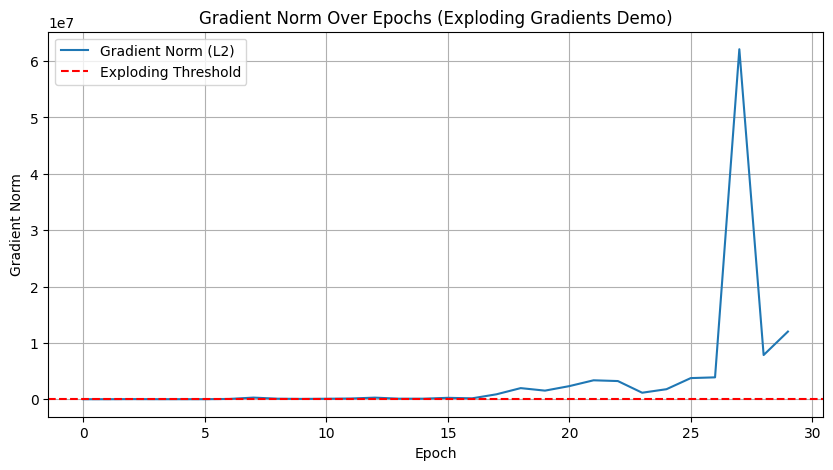

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(grad_norms, label="Gradient Norm (L2)")
plt.axhline(100, color='r', linestyle='--', label="Exploding Threshold")
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm Over Epochs (Exploding Effect)")
plt.legend()
plt.grid(True)
plt.show()

## References

1. https://www.geeksforgeeks.org/machine-learning/introduction-to-recurrent-neural-network/
2. https://www.geeksforgeeks.org/deep-learning/vanishing-and-exploding-gradients-problems-in-deep-learning/